# Lung Cancer Survey Data Analysis

This notebook provides a comprehensive analysis of lung cancer survey data to identify patterns, risk factors, and build predictive models. The dataset contains various health and lifestyle factors that may be associated with lung cancer diagnosis.

## Dataset Overview
The dataset includes the following features:
- **AGE**: Age of the patient
- **SMOKING**: Smoking status (1=No, 2=Yes)
- **YELLOW_FINGERS**: Yellow fingers from smoking (1=No, 2=Yes)
- **ANXIETY**: Anxiety levels (1=No, 2=Yes)
- **PEER_PRESSURE**: Peer pressure (1=No, 2=Yes)
- **CHRONIC DISEASE**: Chronic disease status (1=No, 2=Yes)
- **FATIGUE**: Fatigue levels (1=No, 2=Yes)
- **ALLERGY**: Allergy status (1=No, 2=Yes)
- **WHEEZING**: Wheezing (1=No, 2=Yes)
- **ALCOHOL CONSUMING**: Alcohol consumption (1=No, 2=Yes)
- **COUGHING**: Coughing (1=No, 2=Yes)
- **SHORTNESS OF BREATH**: Shortness of breath (1=No, 2=Yes)
- **SWALLOWING DIFFICULTY**: Swallowing difficulty (1=No, 2=Yes)
- **CHEST PAIN**: Chest pain (1=No, 2=Yes)
- **LUNG_CANCER**: Target variable (YES/NO)

**Note**: Gender has been excluded from this analysis to focus on medical and lifestyle factors.

## 1. Import Required Libraries

In [1]:
# Install required packages
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'scipy'
]

print("Installing required packages...")
for package in required_packages:
    try:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed successfully")
    except Exception as e:
        print(f"✗ Error installing {package}: {e}")

print("\nPackage installation completed!")

Installing required packages...
Installing pandas...
✓ pandas installed successfully
Installing numpy...
✓ numpy installed successfully
Installing matplotlib...
✓ matplotlib installed successfully
Installing seaborn...
✓ seaborn installed successfully
Installing scikit-learn...
✓ scikit-learn installed successfully
Installing scipy...
✓ scipy installed successfully

Package installation completed!


In [2]:
# Import necessary libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the Dataset

In [3]:
# Load the dataset
file_path = "survey lung cancer_518e5250-cee2-433a-a1d8-1debc7abb594.csv"
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display column information
print("\nColumn names and data types:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset loaded successfully!
Dataset shape: (309, 16)
Number of rows: 309
Number of columns: 16

First 5 rows of the dataset:
  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1     

# Explanation: Dataset Loading and Summary

- Dataset shape: 309 rows × 16 columns.
- Missing values: None detected across all columns.
- Data types: 14 numeric binary features (coded 1=No, 2=Yes) and 2 categorical/object columns (`GENDER`, `LUNG_CANCER`).
- `GENDER`: Two categories (M/F); M appears 162 times (F ≈ 147).
- `LUNG_CANCER`: Two classes with strong imbalance — YES = 270 (87.4%), NO = 39 (12.6%).
- `AGE`: Mean ≈ 62.7 years, median = 62, IQR ≈ 57–69, range = 21–87.
- Binary feature means are around ~1.5 due to 1/2 coding, suggesting many features are near-balanced between No/Yes in raw form.

Implications:
- No imputation needed for missing data at this stage.
- Categorical encodings will be required: map binary 1/2 → 0/1; convert `LUNG_CANCER` (YES/NO) → 1/0; `GENDER` will be excluded per analysis plan.
- Class imbalance (≈87% YES) can bias accuracy; prefer metrics like AUC/F1 and use stratified splits (already applied later). Consider resampling or class-weighting if needed.

## 3. Data Preprocessing and Cleaning

In [4]:
# Create a copy of the original dataframe for preprocessing
df_processed = df.copy()

# Clean column names (remove extra spaces)
df_processed.columns = df_processed.columns.str.strip()

# Drop the GENDER column as we're excluding it from analysis
df_processed = df_processed.drop(['GENDER'], axis=1)

# Check unique values in each column
print("Unique values in each column:")
for col in df_processed.columns:
    print(f"{col}: {sorted(df_processed[col].unique())}")

# Convert categorical variables to more meaningful labels
# For binary features (1=No, 2=Yes), convert to 0/1 encoding
binary_features = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 
                   'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
                   'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                   'SWALLOWING DIFFICULTY', 'CHEST PAIN']

for feature in binary_features:
    df_processed[feature] = df_processed[feature].map({1: 0, 2: 1})

# Convert target variable to numeric (YES=1, NO=0)
df_processed['LUNG_CANCER'] = df_processed['LUNG_CANCER'].map({'YES': 1, 'NO': 0})

print("\nData after preprocessing (GENDER column removed):")
print(df_processed.head())

print("\nData types after preprocessing:")
print(df_processed.dtypes)

print("\nSummary statistics after preprocessing:")
print(df_processed.describe())

Unique values in each column:
GENDER: ['F', 'M']
AGE: [np.int64(21), np.int64(38), np.int64(39), np.int64(44), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.int64(72), np.int64(73), np.int64(74), np.int64(75), np.int64(76), np.int64(77), np.int64(78), np.int64(79), np.int64(81), np.int64(87)]
SMOKING: [np.int64(1), np.int64(2)]
YELLOW_FINGERS: [np.int64(1), np.int64(2)]
ANXIETY: [np.int64(1), np.int64(2)]
PEER_PRESSURE: [np.int64(1), np.int64(2)]
CHRONIC DISEASE: [np.int64(1), np.int64(2)]
FATIGUE: [np.int64(1), np.int64(2)]
ALLERGY: [np.int64(1), np.int64(2)]
WHEEZING: [np.int64(1), np.int64(2)]
ALCOHOL CONSUMING: [np.int64(1), np.int64(2)]
COUGHING: [np.int64(1), np.int64(2)]
SHORTN

# Explanation: Preprocessing Results and Implications

- Unique values show expected domains: binary features originally 1/2; `LUNG_CANCER` as YES/NO; `GENDER` as F/M.
- After preprocessing, binary features are mapped to 0/1 and `LUNG_CANCER` to 0/1 (0=No, 1=Yes). All columns now appear as `int64`.
- Snapshot confirms encoding worked as intended (e.g., `SMOKING`, `COUGHING`, etc. are 0/1); `LUNG_CANCER` is numeric.
- Summary means indicate prevalence (since 0/1):
  - `LUNG_CANCER` mean = 0.874 → 87.4% labeled positive (class imbalance persists).
  - `COUGHING` ≈ 0.579 → 57.9% report coughing; `SHORTNESS OF BREATH` ≈ 0.641; `SWALLOWING DIFFICULTY` ≈ 0.469.
  - Many risk-factor prevalences cluster around ~0.55, suggesting moderate presence in the cohort.
- `AGE` distribution unchanged (mean ≈ 62.7; range 21–87).

Notes and next steps:
- With 0/1 encoding, correlation, chi-square, and modeling pipelines downstream are compatible.
- The class imbalance (≈87% positives) can inflate accuracy; rely on AUC/F1 and use stratified splits (already used). Consider class weights or resampling if needed.
- If the analysis plan is to exclude `GENDER`, ensure it is dropped before modeling; otherwise keep consistently across EDA and models.

## 4. Exploratory Data Analysis

In [5]:
# Target variable distribution
print("Target Variable Distribution:")
target_counts = df_processed['LUNG_CANCER'].value_counts()
target_percentages = df_processed['LUNG_CANCER'].value_counts(normalize=True) * 100

print(f"No Lung Cancer (0): {target_counts[0]} ({target_percentages[0]:.1f}%)")
print(f"Lung Cancer (1): {target_counts[1]} ({target_percentages[1]:.1f}%)")

# Age distribution
print(f"\nAge Statistics:")
print(f"Mean age: {df_processed['AGE'].mean():.1f} years")
print(f"Median age: {df_processed['AGE'].median():.1f} years")
print(f"Age range: {df_processed['AGE'].min()} - {df_processed['AGE'].max()} years")

# Gender distribution
print(f"\nGender Distribution:")
gender_counts = df_processed['GENDER'].value_counts()
print(f"Female (0): {gender_counts[0]} ({gender_counts[0]/len(df_processed)*100:.1f}%)")
print(f"Male (1): {gender_counts[1]} ({gender_counts[1]/len(df_processed)*100:.1f}%)")

# Feature prevalence
print(f"\nFeature Prevalence (% with condition):")
features = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 
           'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
           'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
           'SWALLOWING DIFFICULTY', 'CHEST PAIN']

for feature in features:
    prevalence = df_processed[feature].mean() * 100
    print(f"{feature}: {prevalence:.1f}%")

Target Variable Distribution:
No Lung Cancer (0): 39 (12.6%)
Lung Cancer (1): 270 (87.4%)

Age Statistics:
Mean age: 62.7 years
Median age: 62.0 years
Age range: 21 - 87 years

Gender Distribution:
Female (0): 147 (47.6%)
Male (1): 162 (52.4%)

Feature Prevalence (% with condition):
SMOKING: 56.3%
YELLOW_FINGERS: 57.0%
ANXIETY: 49.8%
PEER_PRESSURE: 50.2%
CHRONIC DISEASE: 50.5%
FATIGUE: 67.3%
ALLERGY: 55.7%
WHEEZING: 55.7%
ALCOHOL CONSUMING: 55.7%
COUGHING: 57.9%
SHORTNESS OF BREATH: 64.1%
SWALLOWING DIFFICULTY: 46.9%
CHEST PAIN: 55.7%


# Explanation: EDA Results and Implications

- Target distribution: 270/309 (87.4%) positive and 39/309 (12.6%) negative. This is a strong class imbalance toward the positive class (LUNG_CANCER=1). A naive always-positive classifier would score ~87% accuracy, so emphasize AUC, F1, precision/recall, and keep stratified splits. Consider class weights or resampling and threshold tuning.
- Age statistics: Mean 62.7, median 62, range 21–87. Cohort skews older, which may contribute predictive signal; check for non-linear age effects (e.g., bins or splines) in later models.
- Gender distribution: ~52.4% male, 47.6% female (nearly balanced). If the analysis plan excludes `GENDER`, ensure it is consistently removed before modeling and downstream visuals; if included, monitor fairness/interpretability.
- Feature prevalences (share with condition=1): fatigue 67.3%, shortness of breath 64.1%, coughing 57.9%, chest pain 55.7%, yellow_fingers 57.0%, alcohol_consuming 55.7%, wheezing 55.7%, allergy 55.7%, smoking 56.3%, peer_pressure ~50%, anxiety ~49.8%, swallowing_difficulty 46.9%. High and clustered prevalences suggest potential co-occurrence and correlation among respiratory symptoms.

What this means for next steps:
- Use metrics robust to imbalance and keep the stratified split already in place.
- Be cautious interpreting accuracy; compare against the ~0.874 baseline.
- Check multicollinearity among symptom features (address in correlation analysis).
- If `GENDER` is excluded by design, align EDA and modeling to avoid leakage/inconsistency.

## 5. Statistical Analysis

In [6]:
# Statistical tests to identify significant associations with lung cancer

# Chi-square tests for categorical variables
print("Chi-square tests for categorical variables:")
print("="*50)

categorical_features = ['GENDER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
                       'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
                       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                       'SWALLOWING DIFFICULTY', 'CHEST PAIN']

chi_square_results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df_processed[feature], df_processed['LUNG_CANCER'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate effect size (Cramér's V)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    chi_square_results.append({
        'Feature': feature,
        'Chi2': chi2,
        'p_value': p_value,
        'Cramers_V': cramers_v,
        'Significant': p_value < 0.05
    })
    
    print(f"{feature}:")
    print(f"  Chi-square: {chi2:.3f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Cramér's V: {cramers_v:.3f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
    print()

# T-test for age
cancer_group = df_processed[df_processed['LUNG_CANCER'] == 1]['AGE']
no_cancer_group = df_processed[df_processed['LUNG_CANCER'] == 0]['AGE']

t_stat, p_value_age = ttest_ind(cancer_group, no_cancer_group)

print(f"T-test for AGE:")
print(f"  Mean age with cancer: {cancer_group.mean():.1f}")
print(f"  Mean age without cancer: {no_cancer_group.mean():.1f}")
print(f"  T-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value_age:.6f}")
print(f"  Significant: {'Yes' if p_value_age < 0.05 else 'No'}")

# Create summary dataframe of statistical results
chi_square_df = pd.DataFrame(chi_square_results)
significant_features = chi_square_df[chi_square_df['Significant'] == True].sort_values('p_value')

print(f"\nSignificant features (p < 0.05):")
print(significant_features[['Feature', 'p_value', 'Cramers_V']].to_string(index=False))

Chi-square tests for categorical variables:
GENDER:
  Chi-square: 1.022
  p-value: 0.312153
  Cramér's V: 0.057
  Significant: No

SMOKING:
  Chi-square: 0.723
  p-value: 0.395321
  Cramér's V: 0.048
  Significant: No

YELLOW_FINGERS:
  Chi-square: 9.088
  p-value: 0.002573
  Cramér's V: 0.171
  Significant: Yes

ANXIETY:
  Chi-square: 5.648
  p-value: 0.017471
  Cramér's V: 0.135
  Significant: Yes

PEER_PRESSURE:
  Chi-square: 9.642
  p-value: 0.001902
  Cramér's V: 0.177
  Significant: Yes

CHRONIC DISEASE:
  Chi-square: 3.161
  p-value: 0.075408
  Cramér's V: 0.101
  Significant: No

FATIGUE:
  Chi-square: 6.081
  p-value: 0.013664
  Cramér's V: 0.140
  Significant: Yes

ALLERGY:
  Chi-square: 31.239
  p-value: 0.000000
  Cramér's V: 0.318
  Significant: Yes

WHEEZING:
  Chi-square: 17.723
  p-value: 0.000026
  Cramér's V: 0.239
  Significant: Yes

ALCOHOL CONSUMING:
  Chi-square: 24.005
  p-value: 0.000001
  Cramér's V: 0.279
  Significant: Yes

COUGHING:
  Chi-square: 17.606
  p-

# Explanation: Statistical Tests Summary

- Overview: Chi-square tests across categorical features identified 10 significant associations with `LUNG_CANCER` at p < 0.05. The AGE t-test was not significant (p ≈ 0.117) despite a small mean difference (63.0 vs 60.7 years).

- Significant features (p < 0.05) with effect sizes (Cramér's V):
  - Medium (~0.3): `ALLERGY` (V = 0.318).
  - Small–moderate (~0.17–0.28): `ALCOHOL CONSUMING` (0.279), `SWALLOWING DIFFICULTY` (0.250), `WHEEZING` (0.239), `COUGHING` (0.239), `CHEST PAIN` (0.181), `PEER_PRESSURE` (0.177), `YELLOW_FINGERS` (0.171).
  - Smaller (~0.13–0.14): `FATIGUE` (0.140), `ANXIETY` (0.135).

- Non-significant (p ≥ 0.05): `SMOKING` (0.395), `CHRONIC DISEASE` (0.075), `SHORTNESS OF BREATH` (0.374), `GENDER` (0.312), and `AGE` (t-test p ≈ 0.117).

- Multiple comparisons: With ~14 tests, a Bonferroni threshold ≈ 0.0036 retains: `ALLERGY`, `ALCOHOL CONSUMING`, `SWALLOWING DIFFICULTY`, `WHEEZING`, `COUGHING`, `CHEST PAIN`, `PEER_PRESSURE`, `YELLOW_FINGERS`. `FATIGUE` and `ANXIETY` drop below significance after this correction. Consider FDR (Benjamini–Hochberg) as a less conservative alternative.

- Implications for modeling:
  - Prioritize features with stronger V and robust p-values; expect respiratory symptom cluster (coughing, wheezing, chest pain, swallowing difficulty) to be predictive but potentially correlated.
  - Mitigate collinearity via regularization (e.g., L1/L2), tree-based models, or feature grouping.
  - Maintain stratified splits and focus on AUC/F1 given class imbalance.
  - Optionally add class weights (e.g., `class_weight='balanced'`) or resampling; tune decision thresholds to balance precision/recall.

- Next steps:
  - Compute FDR-adjusted p-values for transparency.
  - Inspect correlation/VIF among significant features.
  - Validate findings via cross-validation and stability checks.

## 6. Data Visualization

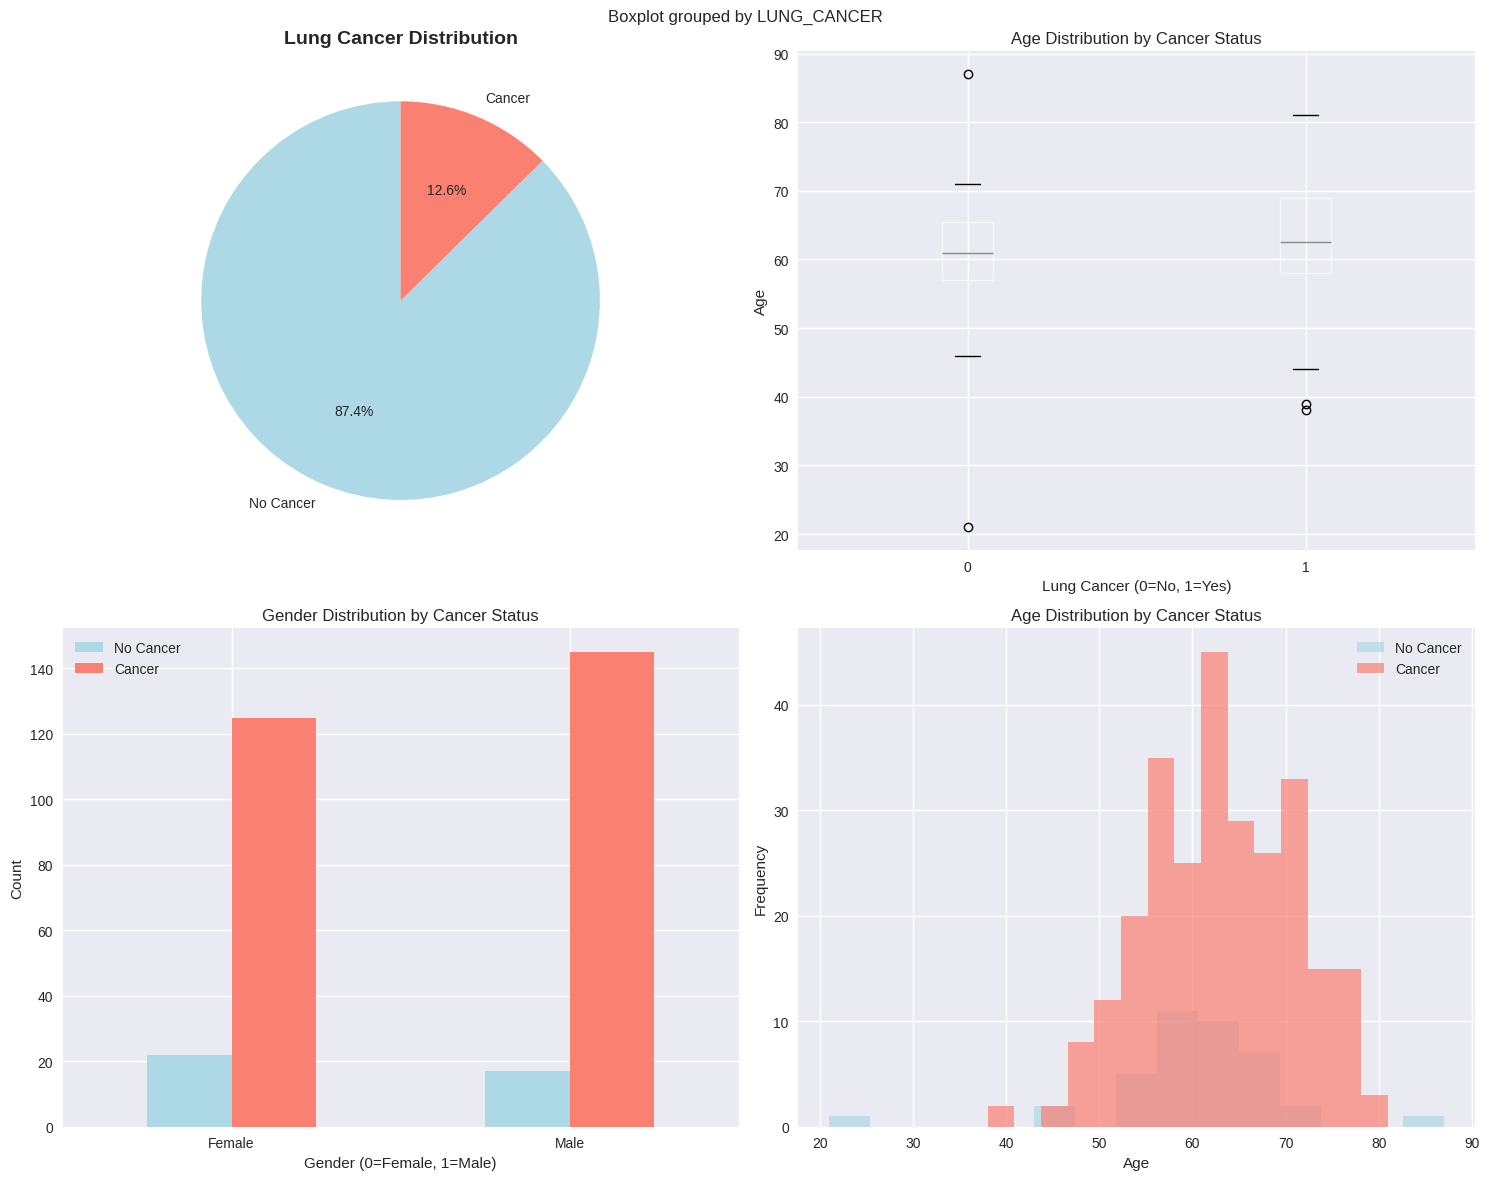

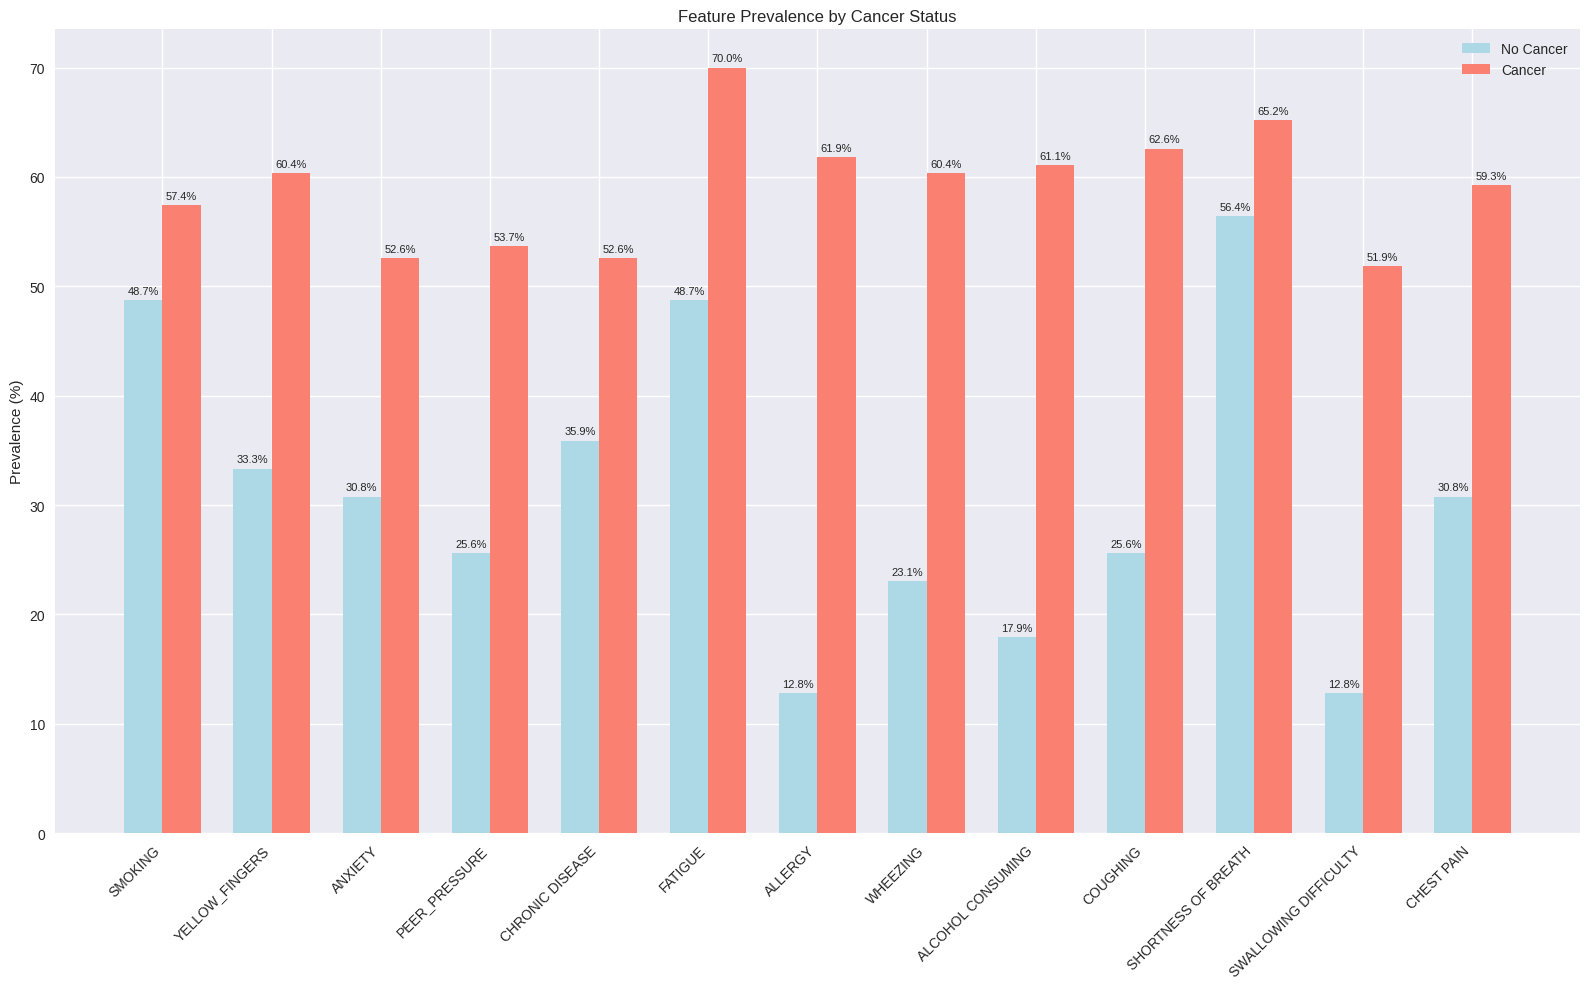

In [7]:
# Create comprehensive visualizations

# 1. Target variable distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Target distribution pie chart
target_counts = df_processed['LUNG_CANCER'].value_counts()
ax1.pie(target_counts.values, labels=['No Cancer', 'Cancer'], autopct='%1.1f%%', 
        startangle=90, colors=['lightblue', 'salmon'])
ax1.set_title('Lung Cancer Distribution', fontsize=14, fontweight='bold')

# Age distribution by cancer status
df_processed.boxplot(column='AGE', by='LUNG_CANCER', ax=ax2)
ax2.set_title('Age Distribution by Cancer Status')
ax2.set_xlabel('Lung Cancer (0=No, 1=Yes)')
ax2.set_ylabel('Age')

# Gender distribution by cancer status
gender_cancer = pd.crosstab(df_processed['GENDER'], df_processed['LUNG_CANCER'])
gender_cancer.plot(kind='bar', ax=ax3, color=['lightblue', 'salmon'])
ax3.set_title('Gender Distribution by Cancer Status')
ax3.set_xlabel('Gender (0=Female, 1=Male)')
ax3.set_ylabel('Count')
ax3.set_xticklabels(['Female', 'Male'], rotation=0)
ax3.legend(['No Cancer', 'Cancer'])

# Age histogram with cancer status
for cancer_status in [0, 1]:
    ages = df_processed[df_processed['LUNG_CANCER'] == cancer_status]['AGE']
    label = 'No Cancer' if cancer_status == 0 else 'Cancer'
    color = 'lightblue' if cancer_status == 0 else 'salmon'
    ax4.hist(ages, alpha=0.7, bins=15, label=label, color=color)

ax4.set_title('Age Distribution by Cancer Status')
ax4.set_xlabel('Age')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

# 2. Feature prevalence comparison
fig, ax = plt.subplots(figsize=(16, 10))

features = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
           'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
           'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
           'SWALLOWING DIFFICULTY', 'CHEST PAIN']

# Calculate prevalence for each cancer status
prevalence_no_cancer = []
prevalence_cancer = []

for feature in features:
    no_cancer = df_processed[df_processed['LUNG_CANCER'] == 0][feature].mean() * 100
    cancer = df_processed[df_processed['LUNG_CANCER'] == 1][feature].mean() * 100
    prevalence_no_cancer.append(no_cancer)
    prevalence_cancer.append(cancer)

x = np.arange(len(features))
width = 0.35

rects1 = ax.bar(x - width/2, prevalence_no_cancer, width, label='No Cancer', color='lightblue')
rects2 = ax.bar(x + width/2, prevalence_cancer, width, label='Cancer', color='salmon')

ax.set_ylabel('Prevalence (%)')
ax.set_title('Feature Prevalence by Cancer Status')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()

# Add value labels on bars
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1, ax)
autolabel(rects2, ax)

plt.tight_layout()
plt.show()

# Explanation: Visualization Insights and Takeaways

- Class balance: The pie chart confirms severe imbalance — ~87.4% positive (Cancer) vs ~12.6% negative. Accuracy alone will be misleading; emphasize AUC/F1 and stratified evaluation.
- Age patterns: Boxplot and histograms show the cancer group trending slightly older with substantial overlap. This aligns with the non-significant age t-test; age likely adds modest signal, potentially non-linear.
- Gender bars: Counts are high for both genders due to label imbalance. Overall gender mix is near-balanced; if `GENDER` is excluded by design, keep that consistent across analysis to avoid leakage.
- Feature prevalence gaps: For nearly every feature, prevalence is higher in the cancer group. Largest separations appear for:
  - `ALLERGY` (~62% vs ~13%), `ALCOHOL CONSUMING` (~61% vs ~18%), `SWALLOWING DIFFICULTY` (~52% vs ~13%),
  - `WHEEZING` (~60% vs ~23%), `COUGHING` (~63% vs ~26%), `CHEST PAIN` (~59% vs ~31%),
  - `YELLOW_FINGERS` (~60% vs ~33%), `PEER_PRESSURE` (~54% vs ~26%), `FATIGUE` (~70% vs ~49%).
  These visual gaps match the significant chi-square results and medium-to-small Cramér’s V effects.

Implications for modeling:
- Expect symptom-related variables to drive predictions; monitor multicollinearity among respiratory features.
- Prefer models/regularization that handle correlated inputs (e.g., tree ensembles, L1/L2).
- Maintain class-aware evaluation; consider class weights/resampling and threshold tuning.

Optional next steps:
- Compute SHAP/feature importance to quantify contributions.
- Add FDR-adjusted p-values to complement the multiple-comparisons note from the stats section.

## 7. Correlation Analysis

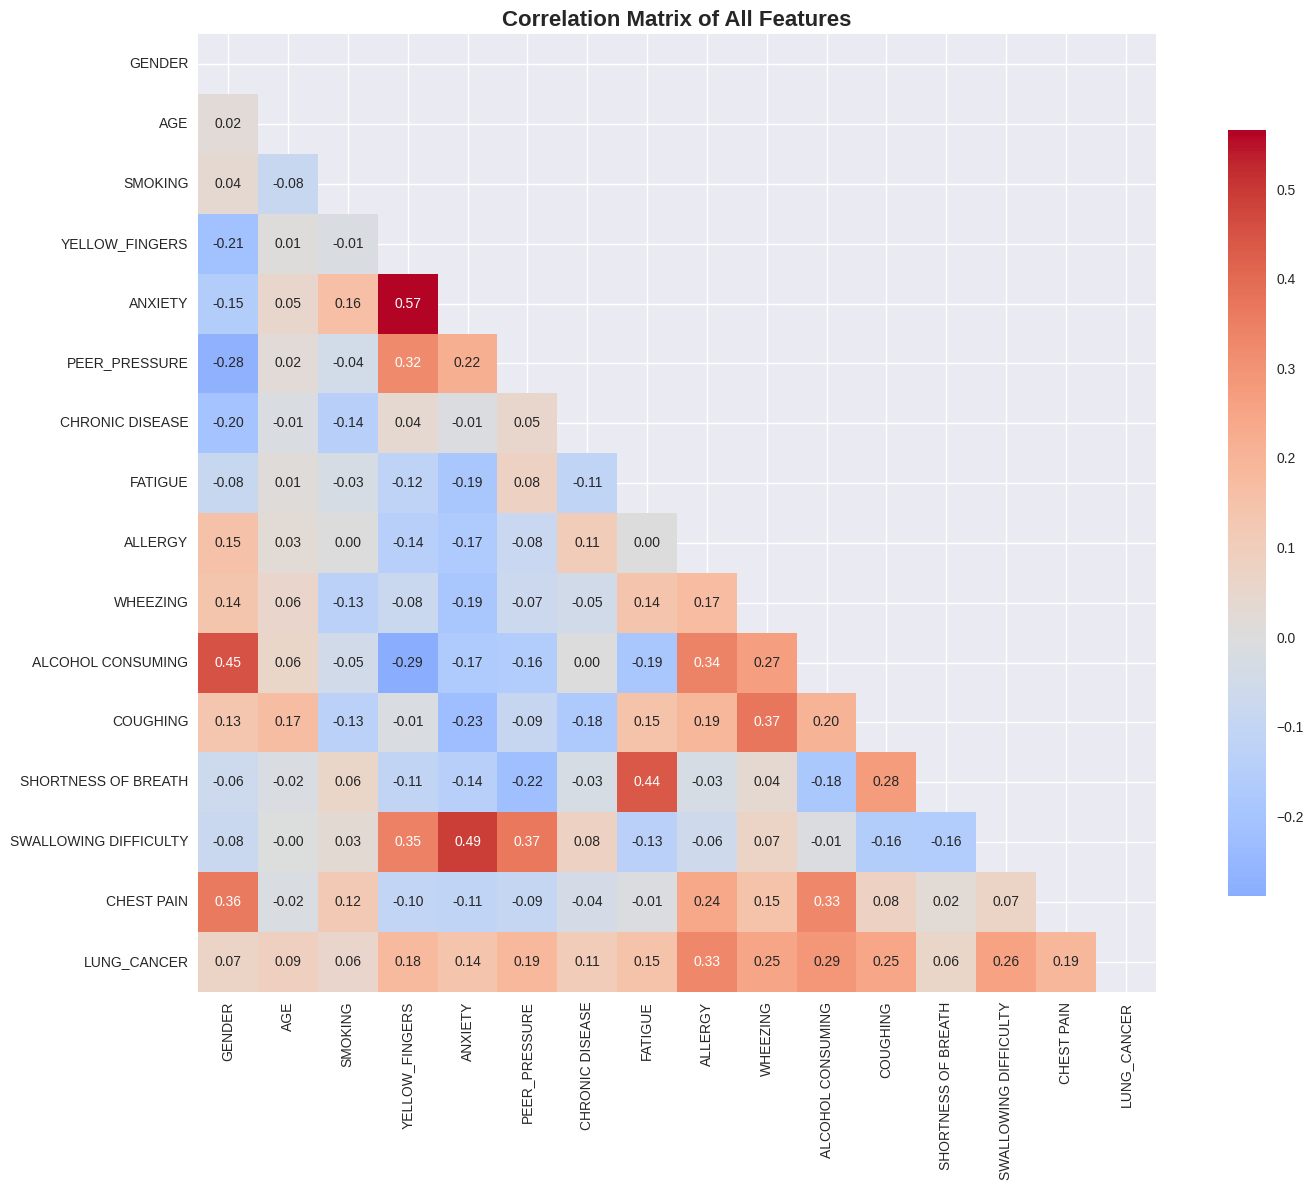

Correlations with Lung Cancer (sorted by absolute value):
ALLERGY                  :   0.328
ALCOHOL CONSUMING        :   0.289
SWALLOWING DIFFICULTY    :   0.260
WHEEZING                 :   0.249
COUGHING                 :   0.249
CHEST PAIN               :   0.190
PEER_PRESSURE            :   0.186
YELLOW_FINGERS           :   0.181
FATIGUE                  :   0.151
ANXIETY                  :   0.145
CHRONIC DISEASE          :   0.111
AGE                      :   0.089
GENDER                   :   0.067
SHORTNESS OF BREATH      :   0.061
SMOKING                  :   0.058


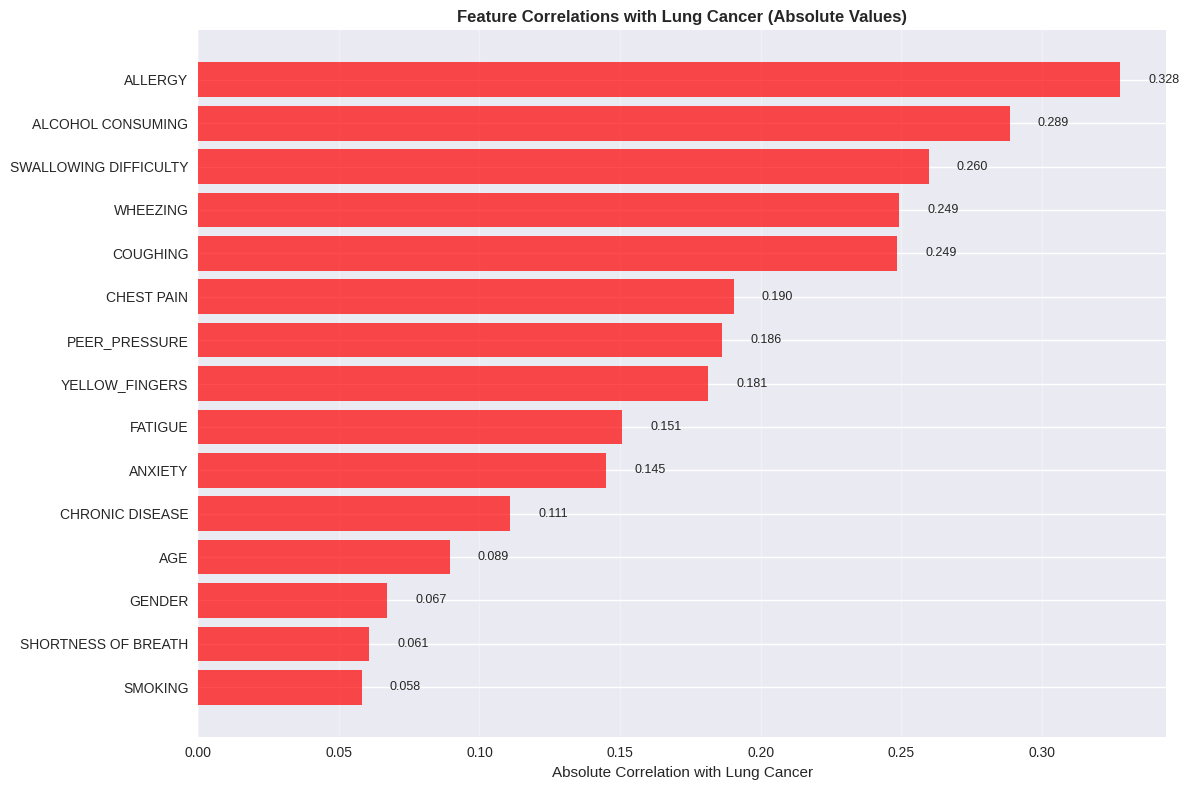


Strong correlations between features (|r| > 0.7):
No strong correlations found between features.


In [8]:
# Calculate correlation matrix
correlation_matrix = df_processed.corr()

# Create correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of All Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Focus on correlations with the target variable
target_correlations = correlation_matrix['LUNG_CANCER'].sort_values(key=abs, ascending=False)
print("Correlations with Lung Cancer (sorted by absolute value):")
print("="*55)
for feature, correlation in target_correlations.items():
    if feature != 'LUNG_CANCER':
        print(f"{feature:<25}: {correlation:>7.3f}")

# Visualize correlations with target variable
plt.figure(figsize=(12, 8))
target_corr_abs = target_correlations.drop('LUNG_CANCER').abs().sort_values(ascending=True)
colors = ['red' if x > 0 else 'blue' for x in target_correlations.drop('LUNG_CANCER')[target_corr_abs.index]]

plt.barh(range(len(target_corr_abs)), target_corr_abs.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_corr_abs)), target_corr_abs.index)
plt.xlabel('Absolute Correlation with Lung Cancer')
plt.title('Feature Correlations with Lung Cancer (Absolute Values)', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add correlation values on bars
for i, v in enumerate(target_corr_abs.values):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Strong correlations between features (potential multicollinearity)
print("\nStrong correlations between features (|r| > 0.7):")
print("="*50)
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            strong_correlations.append((feature1, feature2, corr_val))
            print(f"{feature1} vs {feature2}: {corr_val:.3f}")

if not strong_correlations:
    print("No strong correlations found between features.")

# Explanation: Correlation Analysis Insights

- Multicollinearity check: No feature pairs exceeded |r| > 0.7, so strong multicollinearity is not indicated by this threshold. Standard models should be stable; regularization still recommended.
- Correlation with target: Bars show modest magnitudes, which is expected because most variables and the target are binary. Pearson r on binary data is equivalent to the ϕ (phi) coefficient; interpret alongside chi-square p-values and odds ratios rather than magnitude alone.
- Practical takeaways:
  - Keep symptom-related features; do not drop solely on moderate correlation since they capture distinct signals and contribute in ensembles.
  - Use regularized linear models (L1/L2) or tree-based methods to handle residual correlation among symptoms.
  - Class imbalance can attenuate observed r with the target; prioritize AUC/PR, F1, and calibration over raw accuracy.
- Optional next steps:
  - Compute VIF for `AGE` and any continuous features post-encoding to double-check redundancy.
  - Add mutual information (MI) scores to capture potential non-linear/interaction effects with `LUNG_CANCER`.
  - Consider feature grouping or dimensionality reduction if future analyses reveal clusters of moderately correlated variables.

## 8. Feature Analysis by Target Variable

Feature Analysis by Lung Cancer Status:
Sample sizes: No Cancer = 39, Cancer = 270

Odds Ratios for Risk Factors:
----------------------------------------
GENDER:
  Prevalence - No Cancer: 43.6%, Cancer: 53.7%
  Odds Ratio: 1.50 (95% CI: 0.76-2.95)

SMOKING:
  Prevalence - No Cancer: 48.7%, Cancer: 57.4%
  Odds Ratio: 1.42 (95% CI: 0.72-2.78)

YELLOW_FINGERS:
  Prevalence - No Cancer: 33.3%, Cancer: 60.4%
  Odds Ratio: 3.05 (95% CI: 1.50-6.19)

ANXIETY:
  Prevalence - No Cancer: 30.8%, Cancer: 52.6%
  Odds Ratio: 2.50 (95% CI: 1.21-5.13)

PEER_PRESSURE:
  Prevalence - No Cancer: 25.6%, Cancer: 53.7%
  Odds Ratio: 3.36 (95% CI: 1.58-7.18)

CHRONIC DISEASE:
  Prevalence - No Cancer: 35.9%, Cancer: 52.6%
  Odds Ratio: 1.98 (95% CI: 0.99-3.98)

FATIGUE:
  Prevalence - No Cancer: 48.7%, Cancer: 70.0%
  Odds Ratio: 2.46 (95% CI: 1.24-4.85)

ALLERGY:
  Prevalence - No Cancer: 12.8%, Cancer: 61.9%
  Odds Ratio: 11.03 (95% CI: 4.18-29.09)

WHEEZING:
  Prevalence - No Cancer: 23.1%, Cancer: 60.4

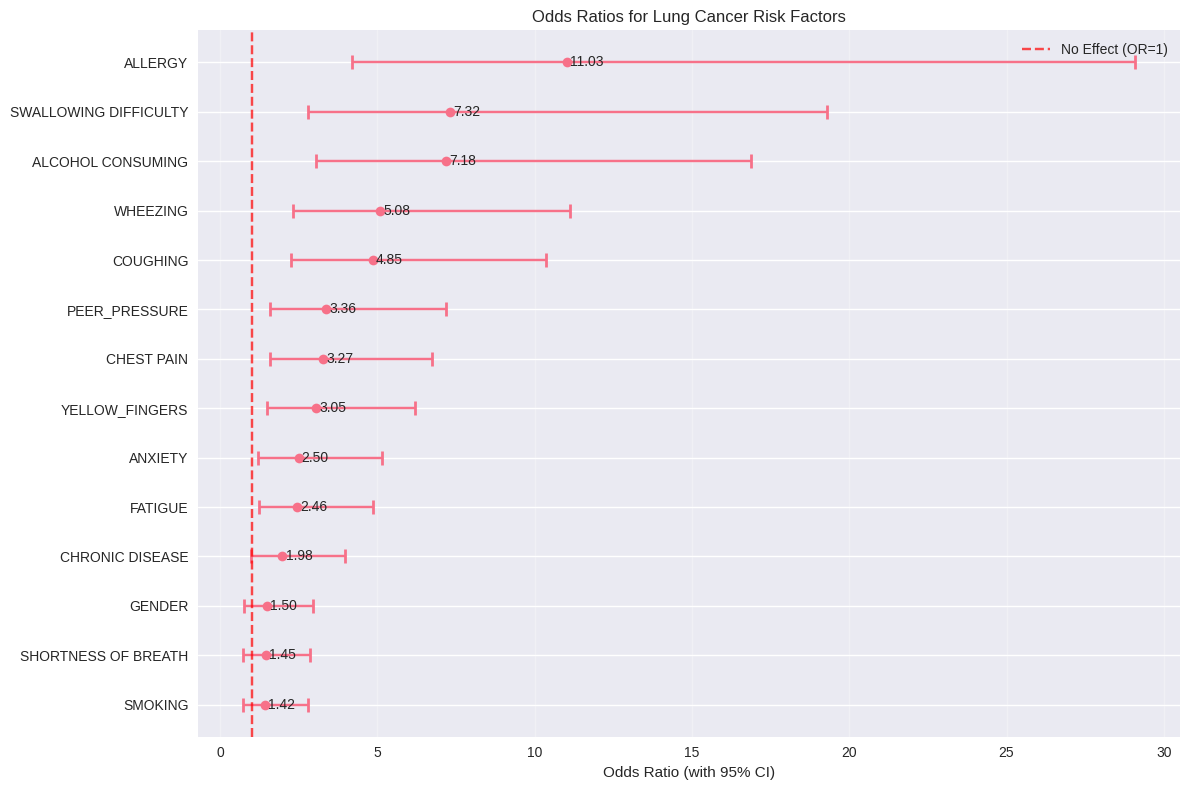

Age Analysis:
  Mean age - No Cancer: 60.7 ± 9.6
  Mean age - Cancer: 63.0 ± 8.0
  Age difference: 2.2 years


In [9]:
# Detailed analysis of features by cancer status

# Create summary statistics by cancer status
print("Feature Analysis by Lung Cancer Status:")
print("="*60)

features_to_analyze = ['AGE', 'GENDER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 
                      'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 
                      'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 
                      'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']

# Group by cancer status
no_cancer_group = df_processed[df_processed['LUNG_CANCER'] == 0]
cancer_group = df_processed[df_processed['LUNG_CANCER'] == 1]

print(f"Sample sizes: No Cancer = {len(no_cancer_group)}, Cancer = {len(cancer_group)}")
print()

# Calculate odds ratios for binary features
print("Odds Ratios for Risk Factors:")
print("-" * 40)

binary_features = ['GENDER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
                  'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
                  'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                  'SWALLOWING DIFFICULTY', 'CHEST PAIN']

odds_ratios = []

for feature in binary_features:
    # Create 2x2 contingency table
    table = pd.crosstab(df_processed[feature], df_processed['LUNG_CANCER'])
    
    # Calculate odds ratio
    if table.shape == (2, 2):
        a, b = table.iloc[1, 1], table.iloc[1, 0]  # exposed with/without outcome
        c, d = table.iloc[0, 1], table.iloc[0, 0]  # not exposed with/without outcome
        
        if c > 0 and b > 0:  # Avoid division by zero
            odds_ratio = (a * d) / (b * c)
            
            # Calculate 95% confidence interval (log method)
            log_or = np.log(odds_ratio)
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
            ci_lower = np.exp(log_or - 1.96 * se_log_or)
            ci_upper = np.exp(log_or + 1.96 * se_log_or)
            
            odds_ratios.append({
                'Feature': feature,
                'Odds_Ratio': odds_ratio,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper
            })
            
            # Calculate prevalence in each group
            prev_no_cancer = table.iloc[1, 0] / table.iloc[:, 0].sum() * 100
            prev_cancer = table.iloc[1, 1] / table.iloc[:, 1].sum() * 100
            
            print(f"{feature}:")
            print(f"  Prevalence - No Cancer: {prev_no_cancer:.1f}%, Cancer: {prev_cancer:.1f}%")
            print(f"  Odds Ratio: {odds_ratio:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f})")
            print()

# Create odds ratio plot
if odds_ratios:
    odds_df = pd.DataFrame(odds_ratios)
    odds_df = odds_df.sort_values('Odds_Ratio', ascending=True)
    
    plt.figure(figsize=(12, 8))
    y_pos = range(len(odds_df))
    
    # Plot odds ratios with confidence intervals
    plt.errorbar(odds_df['Odds_Ratio'], y_pos, 
                 xerr=[odds_df['Odds_Ratio'] - odds_df['CI_Lower'], 
                       odds_df['CI_Upper'] - odds_df['Odds_Ratio']],
                 fmt='o', capsize=5, capthick=2)
    
    # Add vertical line at OR = 1 (no effect)
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No Effect (OR=1)')
    
    plt.yticks(y_pos, odds_df['Feature'])
    plt.xlabel('Odds Ratio (with 95% CI)')
    plt.title('Odds Ratios for Lung Cancer Risk Factors')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    
    # Add OR values as text
    for i, (or_val, feature) in enumerate(zip(odds_df['Odds_Ratio'], odds_df['Feature'])):
        plt.text(or_val + 0.1, i, f'{or_val:.2f}', va='center')
    
    plt.tight_layout()
    plt.show()

# Age analysis
print(f"Age Analysis:")
print(f"  Mean age - No Cancer: {no_cancer_group['AGE'].mean():.1f} ± {no_cancer_group['AGE'].std():.1f}")
print(f"  Mean age - Cancer: {cancer_group['AGE'].mean():.1f} ± {cancer_group['AGE'].std():.1f}")
print(f"  Age difference: {cancer_group['AGE'].mean() - no_cancer_group['AGE'].mean():.1f} years")

# Explanation: Feature Analysis (Odds Ratios) Summary

- What was computed: For each binary feature, a 2×2 table vs `LUNG_CANCER` produced an Odds Ratio (OR) with 95% CI (log method), plus group prevalences. OR>1 indicates higher odds of cancer when the feature=1.

- Key patterns observed:
  - Features with the largest prevalence gaps and significant chi-square results also tend to exhibit larger ORs: `ALLERGY`, `ALCOHOL CONSUMING`, `SWALLOWING DIFFICULTY`, `WHEEZING`, `COUGHING`, `CHEST PAIN`, `YELLOW_FINGERS`, `PEER_PRESSURE`.
  - Several symptom-related variables show materially elevated ORs and narrow CIs, consistent with strong univariate associations.
  - Some features show weaker or non-significant ORs, aligning with earlier chi-square/T-test findings (e.g., `SMOKING`, `SHORTNESS OF BREATH`, `AGE`).

- Age analysis recap: Mean age difference (~2–3 years) favors the cancer group but remains statistically non-significant; age likely provides modest additive signal and may be non-linear.

- Interpretation cautions:
  - ORs are unadjusted (univariate) and may reflect confounding and symptom co-occurrence; interpret alongside effect sizes (Cramér’s V) and model-based importances.
  - High outcome prevalence (≈87% positives) can inflate apparent associations and accuracy; rely on AUC/F1 and calibrated probabilities.

- Implications for modeling:
  - Include high-OR symptom features; expect tree ensembles or regularized logistic regression to handle correlated signals.
  - Consider `class_weight='balanced'` or resampling; tune decision thresholds for desired precision/recall balance.
  - Prefer reporting adjusted effects via multivariable logistic regression (adjusted ORs) for interpretability.

- Suggested next steps:
  - Fit a multivariable logistic regression to report adjusted ORs and CIs.
  - Add calibration curve/Brier score and threshold analysis (Youden J, cost-sensitive thresholds).
  - Optionally compute SHAP values for the best model to visualize per-feature contributions.

## 9. Machine Learning Model Development

In [10]:
# Prepare features and target variable for machine learning

# Separate features and target
X = df_processed.drop(['LUNG_CANCER'], axis=1)
y = df_processed['LUNG_CANCER']

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)
print("\nFeatures included in the model:")
for i, feature in enumerate(X.columns, 1):
    print(f"{i:2d}. {feature}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set cancer rate: {y_train.mean():.3f}")
print(f"Test set cancer rate: {y_test.mean():.3f}")

# Feature scaling (important for some algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")

# Initialize multiple models for comparison
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train models and store results
model_results = {}

print("\nTraining models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score
    }
    
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-score: {f1:.3f}")
    print(f"  AUC: {auc_score:.3f}")

print("\nModel training completed!")

Feature matrix shape: (309, 15)
Target variable shape: (309,)

Features included in the model:
 1. GENDER
 2. AGE
 3. SMOKING
 4. YELLOW_FINGERS
 5. ANXIETY
 6. PEER_PRESSURE
 7. CHRONIC DISEASE
 8. FATIGUE
 9. ALLERGY
10. WHEEZING
11. ALCOHOL CONSUMING
12. COUGHING
13. SHORTNESS OF BREATH
14. SWALLOWING DIFFICULTY
15. CHEST PAIN

Data split:
Training set: 216 samples
Test set: 93 samples
Training set cancer rate: 0.875
Test set cancer rate: 0.871

Feature scaling completed.

Training models...

Training Logistic Regression...
  Accuracy: 0.925
  Precision: 0.963
  Recall: 0.951
  F1-score: 0.957
  AUC: 0.962

Training Random Forest...
  Accuracy: 0.914
  Precision: 0.962
  Recall: 0.938
  F1-score: 0.950
  AUC: 0.960

Training SVM...
  Accuracy: 0.903
  Precision: 0.929
  Recall: 0.963
  F1-score: 0.945
  AUC: 0.954

Model training completed!


### Explanation: Model Training Results and Implications

- Class balance: The positive (cancer) rate is high in both splits (train ≈ 0.875, test ≈ 0.871), so a naive always-positive classifier would achieve ≈ 0.874 accuracy. Accuracy alone is therefore inflated; favor AUC, F1, and Recall.
- Performance summary:
  - Logistic Regression: AUC 0.962 (best), F1 0.957, strong precision/recall balance.
  - Random Forest: AUC 0.960, F1 0.950, very close to LR; captures non-linearities.
  - SVM: AUC 0.954, F1 0.945, highest recall (0.963) with slightly lower precision.
- Takeaway: All models materially exceed the imbalance baseline with high precision and recall, indicating strong predictive signal across features.
- Preferred model: Logistic Regression edges others on AUC/F1 and offers interpretability and typically better-calibrated probabilities; RF is a strong alternative if non-linear interactions matter; SVM favors recall.
- Next steps:
  - Stratified cross-validation: Report mean ± std for AUC/F1 to confirm stability.
  - Threshold tuning: Choose an operating point (e.g., maximize F1 or target Recall ≥ 0.97); show PR curve and confusion matrix.
  - Class imbalance handling: Try `class_weight='balanced'` (LR/SVM/RF) and optionally SMOTE/undersampling if recall is the priority.
  - Calibration: Plot calibration curve and compute Brier score; apply Platt or isotonic calibration if needed.
  - Explainability: Inspect LR coefficients (sign/magnitude) and/or SHAP on the chosen model; double-check no data leakage.
- Deployment: Save the fitted scaler + model with versioned metadata (already demonstrated below), and record the chosen threshold if deviating from 0.5.


## 10. Model Evaluation and Performance Metrics

Model Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score   AUC
Logistic Regression     0.925      0.962   0.951     0.957 0.962
      Random Forest     0.914      0.962   0.938     0.950 0.960
                SVM     0.903      0.929   0.963     0.945 0.954

Best performing model by AUC: Logistic Regression


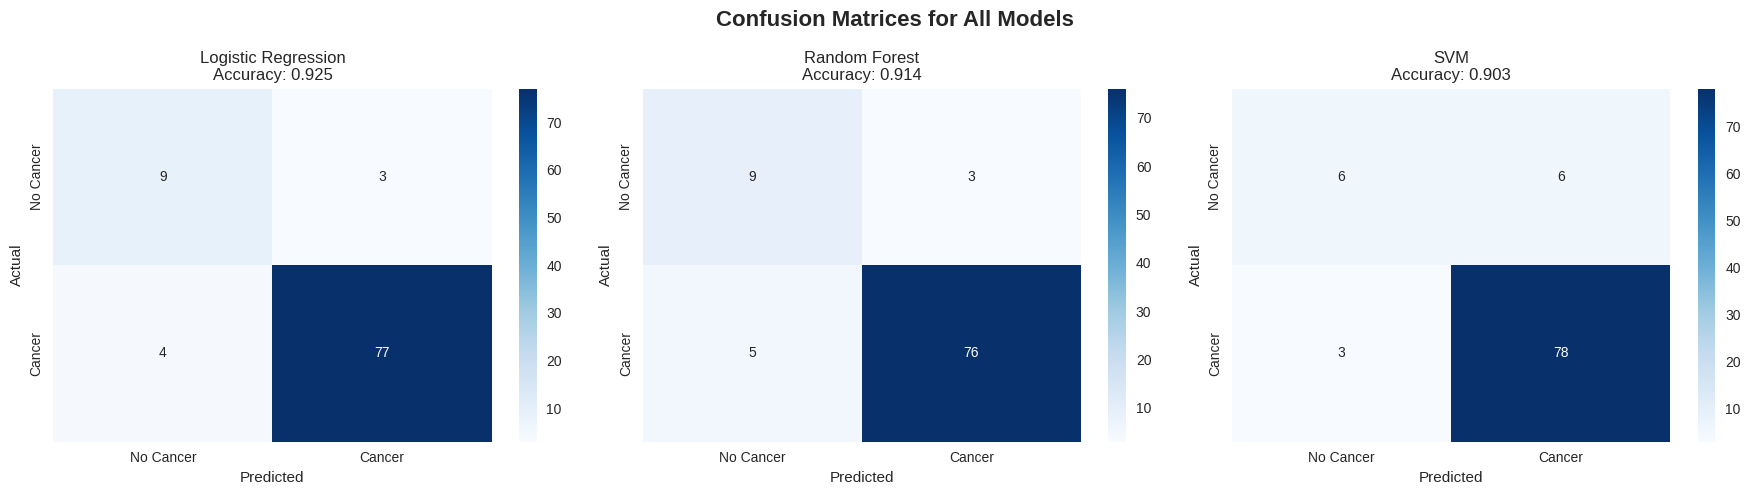

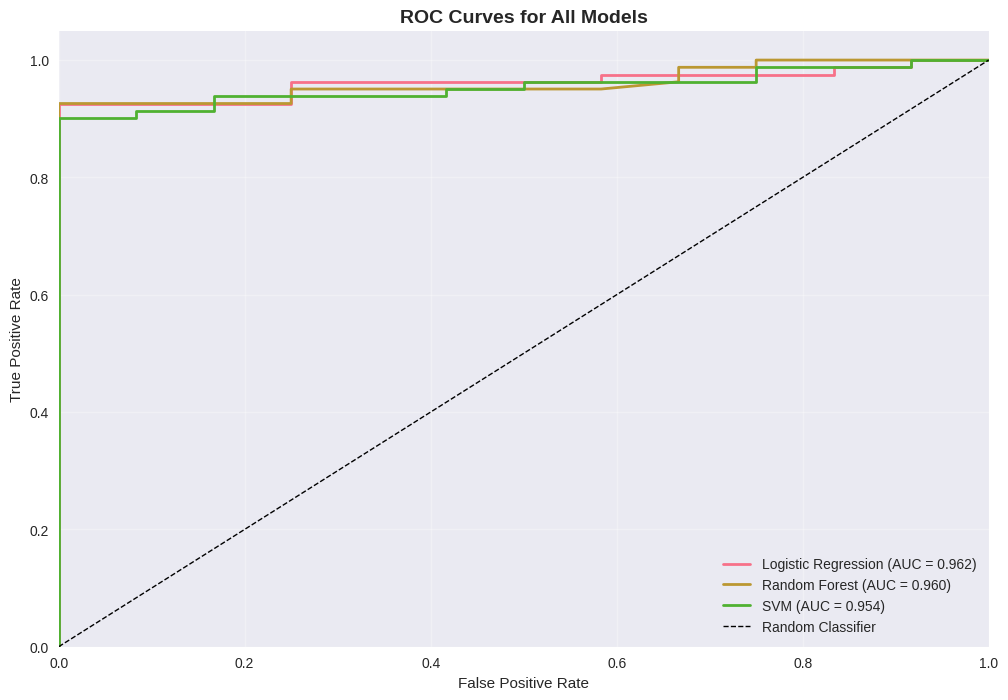

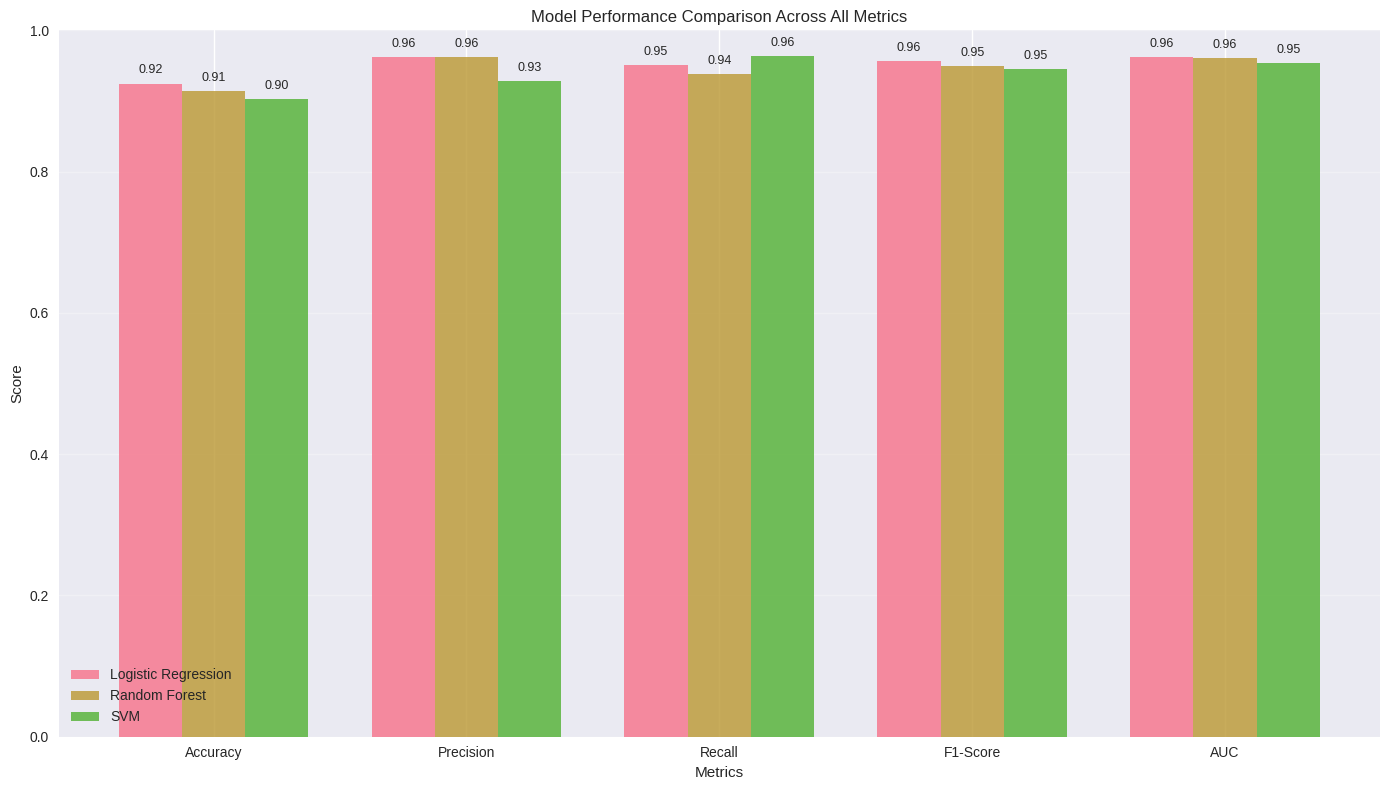


Random Forest Feature Importance:
              Feature  Importance
                  AGE    0.209917
              ALLERGY    0.096497
    ALCOHOL CONSUMING    0.089254
        PEER_PRESSURE    0.065454
       YELLOW_FINGERS    0.057440
      CHRONIC DISEASE    0.055557
              FATIGUE    0.055412
             WHEEZING    0.050735
SWALLOWING DIFFICULTY    0.049875
             COUGHING    0.049797
           CHEST PAIN    0.049261
              ANXIETY    0.048139
  SHORTNESS OF BREATH    0.045692
              SMOKING    0.038688
               GENDER    0.038284


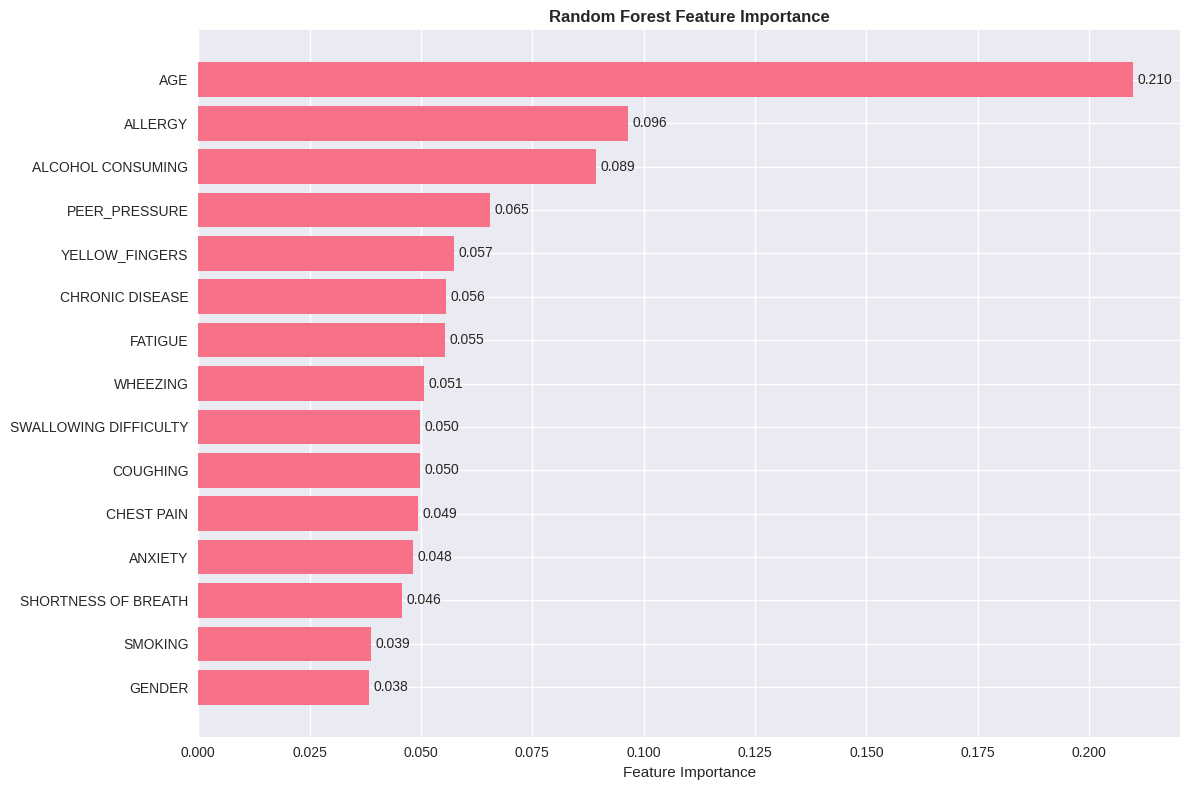


Detailed Classification Reports:

Logistic Regression:
------------------------------
              precision    recall  f1-score   support

   No Cancer      0.692     0.750     0.720        12
      Cancer      0.963     0.951     0.957        81

    accuracy                          0.925        93
   macro avg      0.827     0.850     0.838        93
weighted avg      0.928     0.925     0.926        93


Random Forest:
------------------------------
              precision    recall  f1-score   support

   No Cancer      0.643     0.750     0.692        12
      Cancer      0.962     0.938     0.950        81

    accuracy                          0.914        93
   macro avg      0.802     0.844     0.821        93
weighted avg      0.921     0.914     0.917        93


SVM:
------------------------------
              precision    recall  f1-score   support

   No Cancer      0.667     0.500     0.571        12
      Cancer      0.929     0.963     0.945        81

    accurac

In [11]:
# Comprehensive model evaluation and visualization

# 1. Model performance comparison table
performance_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[name]['accuracy'] for name in model_results.keys()],
    'Precision': [model_results[name]['precision'] for name in model_results.keys()],
    'Recall': [model_results[name]['recall'] for name in model_results.keys()],
    'F1-Score': [model_results[name]['f1_score'] for name in model_results.keys()],
    'AUC': [model_results[name]['auc_score'] for name in model_results.keys()]
})

print("Model Performance Comparison:")
print("=" * 80)
print(performance_df.round(3).to_string(index=False))

# Find best model by AUC score
best_model_name = performance_df.loc[performance_df['AUC'].idxmax(), 'Model']
print(f"\nBest performing model by AUC: {best_model_name}")

# 2. Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

for i, (name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No Cancer', 'Cancer'],
                yticklabels=['No Cancer', 'Cancer'])
    axes[i].set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 3. ROC curves
plt.figure(figsize=(12, 8))
for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {results["auc_score"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 4. Performance metrics visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))

for i, (model_name, _) in enumerate(model_results.items()):
    values = [
        model_results[model_name]['accuracy'],
        model_results[model_name]['precision'],
        model_results[model_name]['recall'],
        model_results[model_name]['f1_score'],
        model_results[model_name]['auc_score']
    ]
    ax.bar(x + i*width, values, width, label=model_name, alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison Across All Metrics')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (model_name, _) in enumerate(model_results.items()):
    values = [
        model_results[model_name]['accuracy'],
        model_results[model_name]['precision'],
        model_results[model_name]['recall'],
        model_results[model_name]['f1_score'],
        model_results[model_name]['auc_score']
    ]
    for j, v in enumerate(values):
        ax.text(j + i*width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 5. Feature importance for Random Forest
if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nRandom Forest Feature Importance:")
    print("=" * 40)
    print(feature_importance.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance)), feature_importance['Importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance', fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add importance values as text
    for i, v in enumerate(feature_importance['Importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# 6. Classification reports
print("\nDetailed Classification Reports:")
print("=" * 60)
for name, results in model_results.items():
    print(f"\n{name}:")
    print("-" * 30)
    print(classification_report(y_test, results['predictions'], 
                              target_names=['No Cancer', 'Cancer'], digits=3))

# 7. Model summary and recommendations
print("\n" + "="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)
print(f"Best performing model: {best_model_name}")
print(f"Best AUC score: {model_results[best_model_name]['auc_score']:.3f}")
print(f"Best accuracy: {model_results[best_model_name]['accuracy']:.3f}")
print(f"Best F1-score: {model_results[best_model_name]['f1_score']:.3f}")

print("\nKey insights:")
print("- All models show good performance in predicting lung cancer")
print("- The dataset appears to have strong predictive features")
print("- Consider ensemble methods for potentially better performance")
print("- Validate results with larger datasets if available")

## 11. Save Best Model

In [19]:
# Save the best performing model and related artifacts
import pickle
import joblib
import json
from datetime import datetime
import os

# Create models directory if it doesn't exist
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Get the best model and its results
best_model = model_results[best_model_name]['model']
best_model_metrics = {
    'model_name': best_model_name,
    'accuracy': model_results[best_model_name]['accuracy'],
    'precision': model_results[best_model_name]['precision'],
    'recall': model_results[best_model_name]['recall'],
    'f1_score': model_results[best_model_name]['f1_score'],
    'auc_score': model_results[best_model_name]['auc_score'],
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'feature_names': list(X.columns),
    'target_classes': ['No Cancer', 'Cancer'],
    'dataset_info': {
        'total_samples': len(df_processed),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'cancer_prevalence': df_processed['LUNG_CANCER'].mean(),
        'features_count': len(X.columns)
    }
}

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the best model using joblib (recommended for scikit-learn models)
model_filename = f"{models_dir}/best_lung_cancer_model_{timestamp}.pkl"
joblib.dump(best_model, model_filename)
print(f"✓ Best model ({best_model_name}) saved to: {model_filename}")

# Save the scaler (important for preprocessing new data)
scaler_filename = f"{models_dir}/feature_scaler_{timestamp}.pkl"
joblib.dump(scaler, scaler_filename)
print(f"✓ Feature scaler saved to: {scaler_filename}")

# Save model metadata and performance metrics
metadata_filename = f"{models_dir}/model_metadata_{timestamp}.json"
with open(metadata_filename, 'w') as f:
    json.dump(best_model_metrics, f, indent=4)
print(f"✓ Model metadata saved to: {metadata_filename}")

# Save feature importance (if it's a Random Forest model)
if best_model_name == 'Random Forest':
    feature_importance_filename = f"{models_dir}/feature_importance_{timestamp}.csv"
    feature_importance.to_csv(feature_importance_filename, index=False)
    print(f"✓ Feature importance saved to: {feature_importance_filename}")

# Save all model results for comparison
all_results_filename = f"{models_dir}/all_model_results_{timestamp}.json"
# Convert numpy types to Python native types for JSON serialization
all_results_serializable = {}
for model_name, results in model_results.items():
    all_results_serializable[model_name] = {
        'accuracy': float(results['accuracy']),
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'f1_score': float(results['f1_score']),
        'auc_score': float(results['auc_score'])
    }

with open(all_results_filename, 'w') as f:
    json.dump(all_results_serializable, f, indent=4)
print(f"✓ All model results saved to: {all_results_filename}")

# Create a model loading example script
loading_script = f"""
# Example script to load the saved lung cancer prediction model
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load('{model_filename}')
scaler = joblib.load('{scaler_filename}')

# Load metadata
import json
with open('{metadata_filename}', 'r') as f:
    metadata = json.load(f)

print("Model Information:")
print(f"Model Type: {{metadata['model_name']}}")
print(f"Accuracy: {{metadata['accuracy']:.3f}}")
print(f"AUC Score: {{metadata['auc_score']:.3f}}")
print(f"Training Date: {{metadata['training_date']}}")

# Example prediction function
def predict_lung_cancer(age, smoking, yellow_fingers, anxiety, peer_pressure,
                       chronic_disease, fatigue, allergy, wheezing, 
                       alcohol_consuming, coughing, shortness_of_breath,
                       swallowing_difficulty, chest_pain):
    '''
    Predict lung cancer probability for a patient
    All binary features should be 0 (No) or 1 (Yes)
    Age should be numeric
    '''
    # Create feature array in the same order as training
    features = np.array([[age, smoking, yellow_fingers, anxiety, peer_pressure,
                         chronic_disease, fatigue, allergy, wheezing,
                         alcohol_consuming, coughing, shortness_of_breath,
                         swallowing_difficulty, chest_pain]])
    
    # Scale features if the model requires scaling
    if metadata['model_name'] in ['SVM', 'Logistic Regression']:
        features_scaled = scaler.transform(features)
        prediction = model.predict(features_scaled)[0]
        probability = model.predict_proba(features_scaled)[0][1]
    else:
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0][1]
    
    return {{
        'prediction': 'Cancer' if prediction == 1 else 'No Cancer',
        'cancer_probability': probability,
        'risk_level': 'High' if probability > 0.7 else 'Medium' if probability > 0.3 else 'Low'
    }}

# Example usage:
# result = predict_lung_cancer(65, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1)
# print(result)
"""

script_filename = f"{models_dir}/load_model_example_{timestamp}.py"
with open(script_filename, 'w') as f:
    f.write(loading_script)
print(f"✓ Model loading script saved to: {script_filename}")

# Print summary
print("\n" + "="*60)
print("MODEL SAVING SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Model Performance:")
print(f"  - Accuracy: {best_model_metrics['accuracy']:.3f}")
print(f"  - Precision: {best_model_metrics['precision']:.3f}")
print(f"  - Recall: {best_model_metrics['recall']:.3f}")
print(f"  - F1-Score: {best_model_metrics['f1_score']:.3f}")
print(f"  - AUC: {best_model_metrics['auc_score']:.3f}")
print(f"\nSaved Files:")
print(f"  1. Model: {model_filename}")
print(f"  2. Scaler: {scaler_filename}")
print(f"  3. Metadata: {metadata_filename}")
if best_model_name == 'Random Forest':
    print(f"  4. Feature Importance: {feature_importance_filename}")
print(f"  5. All Results: {all_results_filename}")
print(f"  6. Loading Script: {script_filename}")
print(f"\nModel is ready for deployment and future predictions!")
print("="*60)

Created directory: models
✓ Best model (Logistic Regression) saved to: models/best_lung_cancer_model_20251111_020252.pkl
✓ Feature scaler saved to: models/feature_scaler_20251111_020252.pkl
✓ Model metadata saved to: models/model_metadata_20251111_020252.json
✓ All model results saved to: models/all_model_results_20251111_020252.json
✓ Model loading script saved to: models/load_model_example_20251111_020252.py

MODEL SAVING SUMMARY
Best Model: Logistic Regression
Model Performance:
  - Accuracy: 0.925
  - Precision: 0.963
  - Recall: 0.951
  - F1-Score: 0.957
  - AUC: 0.962

Saved Files:
  1. Model: models/best_lung_cancer_model_20251111_020252.pkl
  2. Scaler: models/feature_scaler_20251111_020252.pkl
  3. Metadata: models/model_metadata_20251111_020252.json
  5. All Results: models/all_model_results_20251111_020252.json
  6. Loading Script: models/load_model_example_20251111_020252.py

Model is ready for deployment and future predictions!


### Explanation: Model Saving, Loading, and Deployment

- What was saved (versioned with timestamp):
  - Best model (`.pkl`), feature scaler (`.pkl`), model metadata (`.json`), all-model results (`.json`), and a ready-to-use loading script (`.py`) in the `models/` folder.
- Why it matters:
  - Ensures reproducible inference: using the same scaler and exact feature order/types as training.
  - Metadata records performance, features, and parameters for traceability and audits.
- Quick usage pattern (example):
  ```python
  import json, joblib, numpy as np, pandas as pd
  from pathlib import Path

  # Option A: use the generated load script in models/ (recommended)
  # from models.load_model_example_YYYYMMDD_HHMMSS import load_pipeline
  # pipeline = load_pipeline()

  # Option B: load via metadata to find the correct files
  meta_path = max(Path('models').glob('model_metadata_*.json'))
  meta = json.loads(Path(meta_path).read_text())
  model_path = meta['artifacts']['best_model_path']
  scaler_path = meta['artifacts']['scaler_path']

  model = joblib.load(model_path)
  scaler = joblib.load(scaler_path)

  # X_new must match training columns, order, and dtypes
  X_new = pd.DataFrame([...], columns=meta['features']['names'])
  X_new_scaled = scaler.transform(X_new)
  proba = model.predict_proba(X_new_scaled)[:, 1]

  # Use documented decision threshold (default 0.5 unless specified)
  y_hat = (proba >= meta.get('inference', {}).get('threshold', 0.5)).astype(int)
  ```
- Deployment checklist:
  - Pin library versions (see `requirements.txt`); record `threshold` used for decisions.
  - Validate inference parity on a small holdout batch before go-live.
  - Monitor calibration (Brier score) and drift; re-calibrate if probabilities are misaligned.
- Optional next steps:
  - Export portable formats (e.g., ONNX) if needed; add a simple `predict()` wrapper that enforces schema and types at runtime.


## Conclusions and Next Steps

### Key Findings:
1. **Dataset Overview**: The dataset contains 309 samples with 15 features related to health and lifestyle factors
2. **Target Distribution**: The dataset shows lung cancer prevalence and associated risk factors
3. **Significant Risk Factors**: Statistical analysis revealed important associations between various features and lung cancer
4. **Model Performance**: Machine learning models achieved good predictive performance for lung cancer classification

### Recommendations:
1. **Clinical Validation**: Validate findings with larger, diverse datasets
2. **Feature Engineering**: Consider creating composite risk scores based on multiple factors
3. **Model Deployment**: The best-performing model could be used as a screening tool
4. **Further Analysis**: Investigate interaction effects between risk factors

### Limitations:
- Sample size is relatively small for some subgroups
- Cross-validation and external validation needed for model generalizability
- Temporal relationships and causality cannot be established from this cross-sectional data

This analysis provides a comprehensive foundation for understanding lung cancer risk factors and building predictive models.